In [1]:
import sys

sys.path.append("../src")
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from utils.make_eqs import make_random_eq

In [2]:
path = "../data/spec_3sec/blues/blues.00000/blues.00000_0.npy"
spec = np.load(path)
print(spec.shape)
print(spec.dtype)

(1025, 130)
complex64


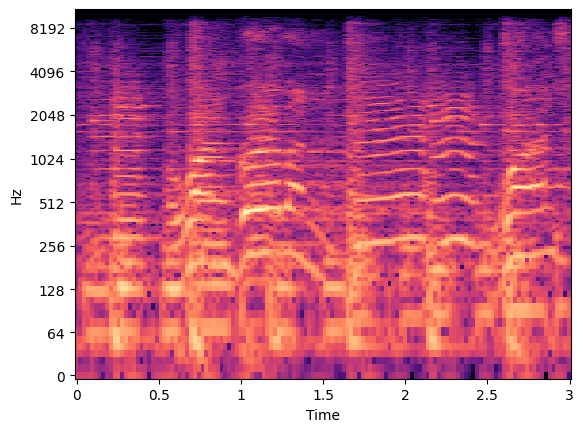

In [3]:
magspec = np.abs(spec)
librosa.display.specshow(
    librosa.amplitude_to_db(magspec, ref=np.max), y_axis="log", x_axis="time"
)

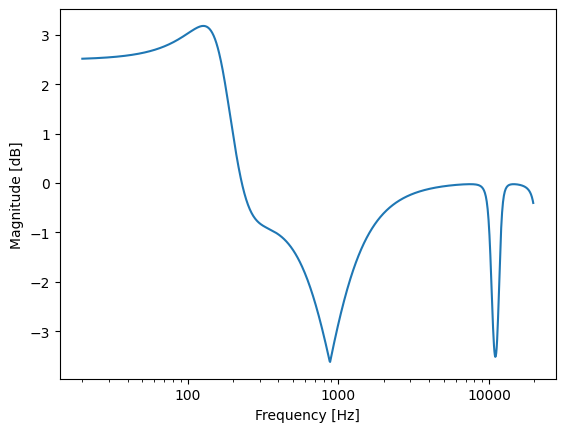

In [4]:
# eq = np.random.rand(spec.shape[0])
# print(eq.shape)
# plt.plot(eq)

import audio_dspy as adsp
import numpy as np
import matplotlib.pyplot as plt

fs = 44100 // 2  # sample rate
worN = np.logspace(1, 3.3, num=1000, base=20)  # frequencies to plot

# design EQ
eq = adsp.EQ(fs)
eq.add_LPF(10000, 0.707)
eq.add_lowshelf(200, 1.4, 2)
eq.add_notch(880, 0.707)


# plot EQ magnitude response
eq.plot_eq_curve(worN=worN)
plt.show()

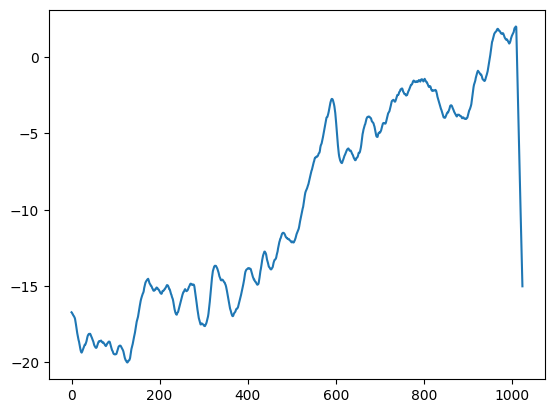

In [5]:
filter = np.load("../data/random_walk_eqs_db/00000.npy")
plt.plot(filter)
plt.show()

In [23]:
import torch


def interp(
    x: torch.Tensor,
    xp: torch.Tensor,
    fp: torch.Tensor,
    dim: int = -1,
    extrapolate: str = "constant",
) -> torch.Tensor:
    """One-dimensional linear interpolation between monotonically increasing sample
    points, with extrapolation beyond sample points.

    Returns the one-dimensional piecewise linear interpolant to a function with
    given discrete data points :math:`(xp, fp)`, evaluated at :math:`x`.

    Args:
        x: The :math:`x`-coordinates at which to evaluate the interpolated
            values.
        xp: The :math:`x`-coordinates of the data points, must be increasing.
        fp: The :math:`y`-coordinates of the data points, same shape as `xp`.
        dim: Dimension across which to interpolate.
        extrapolate: How to handle values outside the range of `xp`. Options are:
            - 'linear': Extrapolate linearly beyond range of xp values.
            - 'constant': Use the boundary value of `fp` for `x` values outside `xp`.

    Returns:
        The interpolated values, same size as `x`.
    """
    # Move the interpolation dimension to the last axis
    x = x.movedim(dim, -1)
    xp = xp.movedim(dim, -1)
    fp = fp.movedim(dim, -1)

    m = torch.diff(fp) / torch.diff(xp)  # slope
    b = fp[..., :-1] - m * xp[..., :-1]  # offset
    indices = torch.searchsorted(xp, x, right=False)

    if extrapolate == "constant":
        # Pad m and b to get constant values outside of xp range
        m = torch.cat(
            [torch.zeros_like(m)[..., :1], m, torch.zeros_like(m)[..., :1]], dim=-1
        )
        b = torch.cat([fp[..., :1], b, fp[..., -1:]], dim=-1)
    else:  # extrapolate == 'linear'
        indices = torch.clamp(indices - 1, 0, m.shape[-1] - 1)

    values = m.gather(-1, indices) * x + b.gather(-1, indices)

    return values.movedim(-1, dim)

torch.Size([2, 1025])
torch.Size([2, 1025])


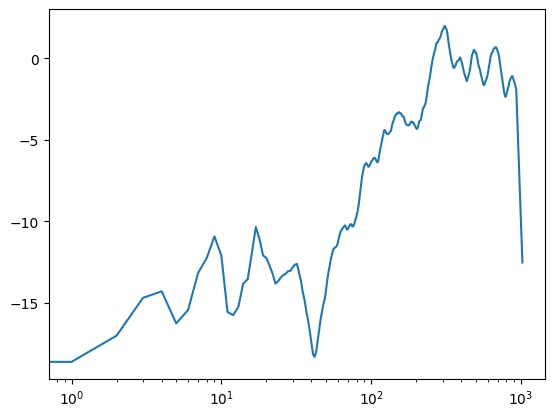

In [134]:
import torch
from torch.nn import functional as F

filter1 = make_random_eq(1025)
filter2 = make_random_eq(1025)
filter = np.vstack([filter1, filter2])
filter = torch.tensor(filter)
print(filter.shape)


interp_eq = interp(
    torch.linspace(1, 1025, 1025).unsqueeze(0).repeat(2, 1),
    torch.logspace(0, np.log10(1025), 1025).unsqueeze(0).repeat(2, 1),
    filter,
)
print(interp_eq.shape)
plt.plot(interp_eq[1].squeeze().numpy())
plt.xscale("log")
plt.show()


# x_log_interp = np.logspace(0, np.log10(1024), num=1025 * 100, base=10)

# lin_freq = np.linspace(0, 1024, 1025)
# lin_freq_eq = np.interp(lin_freq, x_log_interp, interp_eq)
# print(lin_freq_eq.shape)
# plt.plot(lin_freq_eq)
# plt.show()

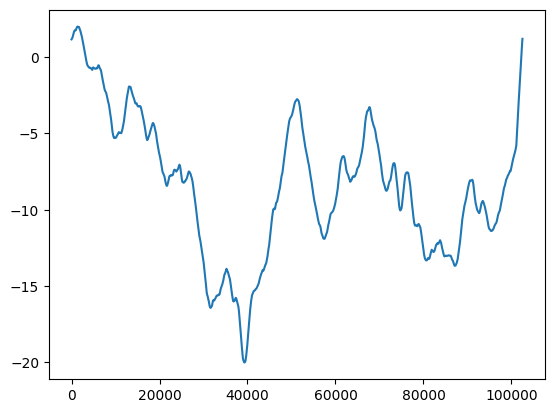

(1025,)


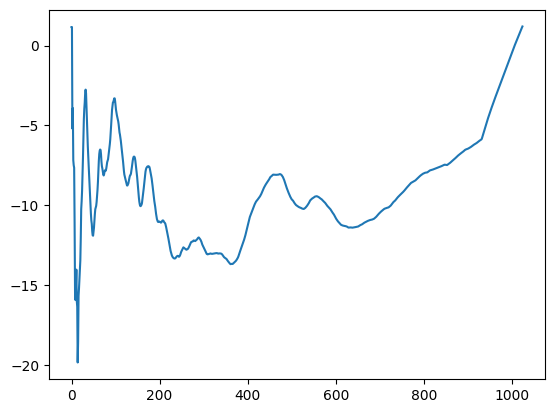

In [7]:
x_interp = np.linspace(0, 1024, 1025 * 100)
interp_eq = np.interp(x_interp, np.linspace(0, 1024, 1025), filter)
plt.plot(interp_eq)
plt.show()


x_log_interp = np.logspace(0, np.log10(1024), num=1025 * 100, base=10)

lin_freq = np.linspace(0, 1024, 1025)
lin_freq_eq = np.interp(lin_freq, x_log_interp, interp_eq)
print(lin_freq_eq.shape)
plt.plot(lin_freq_eq)
plt.show()

In [8]:
magspec_eq = magspec * filter[:, np.newaxis]

In [9]:
# spec_eq = magspec_eq * np.exp(1j * np.angle(spec))
eq_spec = spec * filter[:, np.newaxis]
wav = librosa.istft(eq_spec)
ipd.Audio(wav, rate=22050)

In [10]:
orig_wav = librosa.istft(spec)
ipd.Audio(orig_wav, rate=22050)

In [11]:
restored_magspec = magspec_eq * inv_filter[:, np.newaxis]
restored_spec = restored_magspec * np.exp(1j * np.angle(spec))
restored_wav = librosa.istft(restored_spec)
ipd.Audio(restored_wav, rate=22050)

NameError: name 'inv_filter' is not defined